In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [2]:
import time

import numpy as np

from rmrl.experiments.configurations import *
from rmrl.experiments.with_transfer import WithTransferExperiment
from rmrl.experiments.runner import ExperimentsRunner
from rmrl.utils.misc import sha3_hash

import matplotlib.pyplot as plt

SEED = 42

EXPERIMENT_NAME = ''

In [3]:
def get_simple_exp(seed=SEED, extra_mod=None):
    return WithTransferExperiment(
        cfg=ExperimentConfiguration(
            env=SupportedEnvironments.SMALL,
            cspace=ContextSpaces.FIXED_ENTITIES,
            alg=Algos.PPO,
            mods=[Mods.AS, Mods.RS] + ([extra_mod] if extra_mod else []),
            rm_kwargs={
                'grid_resolution': (2, 2)
            },
            model_kwargs=dict(
                gnn_hidden_dims=[32, 32],
            ),
            alg_kwargs={
                # 'learning_starts': 0,
                # 'exploration_fraction': 0.5,
                'n_steps': 1024
            },
            seed=seed
        ),
        total_timesteps=1e5,
        dump_dir='single_experiment_dumps',
        verbose=1,
        log_interval=1,
        eval_freq=500,
        min_evals=10,
        n_eval_episodes=10,
    )

no_geco_exp = get_simple_exp()
with_geco_exp = get_simple_exp(extra_mod=Mods.GECO)
geco_upt_exp = get_simple_exp(extra_mod=Mods.GECOUPT)

In [15]:
pairs = ExperimentsRunner.load_or_sample_contexts(exp=no_geco_exp,
                                                           num_samples=3,
                                                           sample_seed=24)

src, tgt = pairs[1]

src_name = sha3_hash(src)
tgt_name = sha3_hash(tgt)

In [16]:
src_env = no_geco_exp.get_env_for_context(src)
src_env.reset()
print('src context')
src_env.render()

tgt_env = no_geco_exp.get_env_for_context(tgt)
tgt_env.reset()
print('tgt context')
tgt_env.render()

src context
+-------+
| : | : |
| : : :P|
| : | | |
| | | : |
+-------+
Taxi0-YELLOW: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 0/25, ALIVE
Passenger0-YELLOW: Location: (1, 3), Destination: (-1, -1)
Env done: False

tgt context
+-------+
| : | : |
| : : : |
| : | |P|
| | | : |
+-------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: False, Step: 0/25, ALIVE
Passenger0-YELLOW: Location: (2, 3), Destination: (-1, -1)
Env done: False



In [17]:
no_transfer_res = np.load(no_geco_exp.eval_log_dir / tgt_name / 'evaluations.npz')
with_transfer_res = np.load(no_geco_exp.eval_log_dir / 
                            f'{tgt_name}_transfer_from_{src_name}' / 
                            'evaluations.npz')

geco_no_transfer_res = np.load(with_geco_exp.eval_log_dir / tgt_name / 'evaluations.npz')
geco_with_transfer_res = np.load(with_geco_exp.eval_log_dir / 
                            f'{tgt_name}_transfer_from_{src_name}' / 
                            'evaluations.npz')

gecoupt_no_transfer_res = np.load(geco_upt_exp.eval_log_dir / tgt_name / 'evaluations.npz')
gecoupt_with_transfer_res = np.load(geco_upt_exp.eval_log_dir / 
                            f'{tgt_name}_transfer_from_{src_name}' / 
                            'evaluations.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'single_experiment_dumps/WithTransferExperiment/env-small/cspace-fixed_entities/alg-PPO/mods-(AS,RS,GECOUPT)/rm_kwargs-((grid_resolution-(2,2)))/alg_kwargs-((n_steps-1024))/model_kwargs-((gnn_hidden_dims-(32,32)))/seed-48/logs/eval/2f7b4f8a8b91ff2d752157422029fe71a56a048e3f37a07602ae2e559bdf6a42/evaluations.npz'

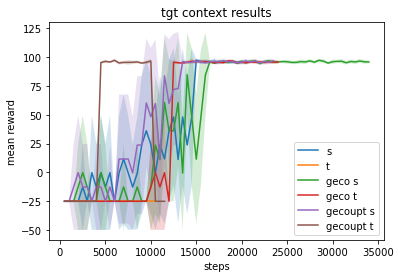

In [18]:
def plotter(npz, label):
    x = npz['timesteps']
    ys = npz['results']
    means = np.mean(ys, axis=-1)
    stds = np.std(ys, axis=-1)
    
    # if label in ['t', 's']:
    #     x = x[:20000]
    #     means = means[:20000]
    plt.plot(x, means, label=label)
    plt.fill_between(x, means - stds, means + stds, alpha=0.2)


plt.figure()
plt.title('tgt context results')
plt.xlabel('steps')
plt.ylabel('mean reward')
plotter(no_transfer_res, label='s')
plotter(with_transfer_res, label='t')
plotter(geco_no_transfer_res, label='geco s')
plotter(geco_with_transfer_res, label='geco t')
plotter(gecoupt_no_transfer_res, label='gecoupt s')
plotter(gecoupt_with_transfer_res, label='gecoupt t')
plt.legend()

In [11]:
src_res = np.load(no_geco_exp.eval_log_dir / src_name / 'evaluations.npz')
geco_src_res = np.load(with_geco_exp.eval_log_dir / src_name / 'evaluations.npz')
gecoupt_src_res = np.load(geco_upt_exp.eval_log_dir / src_name / 'evaluations.npz')

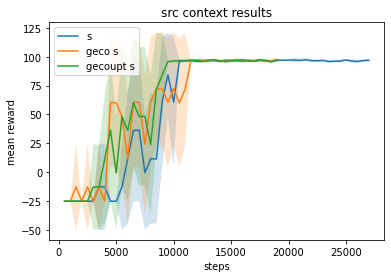

In [12]:
plt.figure()
plt.title('src context results')
plt.xlabel('steps')
plt.ylabel('mean reward')
plotter(src_res, label='s')
plotter(geco_src_res, label='geco s')
plotter(gecoupt_src_res, label='gecoupt s')
plt.legend()